In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ner-dataset/ner_datasetreference.csv


In [2]:
data = pd.read_csv('/kaggle/input/ner-dataset/ner_datasetreference.csv', encoding='latin1')

In [3]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data = data.fillna(method='ffill')

In [5]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        agg_function = lambda s: [(w, p, s) for w, p, s in zip(s['Word'].values.tolist(),
                                                              s['POS'].values.tolist(),
                                                              s['Tag'].values.tolist())]
        
        self.group = self.data.groupby('Sentence #').apply(agg_function)
        self.sentence = [s for s in self.group]
        
#     def get_next(self,data):
        

In [7]:
getter = GetSentence(data)

In [8]:
sentence = [[word[0] for word in sentence] for sentence in getter.sentence]

In [9]:
sentence[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [10]:
labels = [[lab[2] for lab in sentence] for sentence in getter.sentence]

In [11]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [12]:
tag_values = list(set(data["Tag"].values))

In [13]:
tag_values

['I-tim',
 'B-org',
 'I-org',
 'B-gpe',
 'I-art',
 'B-per',
 'O',
 'I-per',
 'I-gpe',
 'I-nat',
 'B-nat',
 'B-geo',
 'B-eve',
 'I-eve',
 'B-tim',
 'I-geo',
 'B-art']

In [14]:
tag_values.append('PAD')

In [15]:
tag_idx = {t: i for i, t in enumerate(tag_values)}

In [16]:
tag_idx

{'I-tim': 0,
 'B-org': 1,
 'I-org': 2,
 'B-gpe': 3,
 'I-art': 4,
 'B-per': 5,
 'O': 6,
 'I-per': 7,
 'I-gpe': 8,
 'I-nat': 9,
 'B-nat': 10,
 'B-geo': 11,
 'B-eve': 12,
 'I-eve': 13,
 'B-tim': 14,
 'I-geo': 15,
 'B-art': 16,
 'PAD': 17}

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [18]:
torch.__version__

'1.9.1'

In [19]:
# !pip install transformers

In [20]:
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split

In [21]:
MAX_LEN = 75
BATCH_SIZE = 16

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
print(torch.cuda.device_count())

1


In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [25]:
def tokenize_preserve(sentences,text_labels):
    tokenized_sentence = []
    labels = []
    
    for word, label in zip(sentences,text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)
    
    return tokenized_sentence, labels
        

In [26]:
tokenized_texts_and_labels = [
  tokenize_preserve(sent,labs)
  for sent,labs in zip(sentence,labels)
]

In [27]:
tokenized_text = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1]for token_label_pair in tokenized_texts_and_labels] 

In [28]:
len(tokenized_text[0]) , len(labels[0])

(26, 26)

In [29]:
from keras_preprocessing.sequence import pad_sequences

In [30]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                         maxlen=MAX_LEN, dtype='long',value=0.0,
                         truncating='post',padding='post')

In [31]:
tags = pad_sequences([[tag_idx.get(l)for l in lab]for lab in labels],
                    maxlen=MAX_LEN, dtype='long', value=tag_idx['PAD'],
                    truncating='post',padding='post')

In [32]:
attention_masks = [[float(i !=0.0)for i in ii]for ii in input_ids]

In [33]:
tr_input, val_input, tr_tag, val_tag = train_test_split(input_ids,tags,random_state=45,test_size=.1)

In [34]:
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=45, test_size=.1)

In [35]:
len(tr_masks[0]),len(tr_input[0]), len(tr_tag[0])
print(tr_masks[0]), print(tr_input[0]), print(tr_tag[0]) 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[10000  2110  4108 19496  1335  5971  1183  1163  1175  1108  1185  6281
  5088  1106 12010   119     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[ 6  6  5  5  7  7  7  6  6  6  6  6  6  6  6  6 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 1

(None, None, None)

In [36]:
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)
tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [37]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(tr_input, tr_masks, tr_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [38]:
from transformers import BertForTokenClassification, AdamW

In [39]:
model = BertForTokenClassification.from_pretrained(
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [40]:
# model.cuda()

In [41]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [42]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [45]:
!pip install seqeval

     |████████████████████████████████| 43 kB 285 kB/s eta 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=5bccef6a8d95b82b14a3af380bdb3eb94001ac9a9f009df37fcca0c6bf819664
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [46]:
from seqeval.metrics import f1_score, accuracy_score

In [52]:
from tqdm import tqdm, trange

In [54]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [57]:
#storing loss values
loss_values, validation_loss_values = [], []

#TRAINING AND VALIDATION

for _ in trange(epochs, desc= "Epoch"):
    #/|\==>TRAINLOOP(ONEPASS)<==\|/
    model.train()
    total_loss=0 #so it resets each epoch
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch #also the order in train_data/val_data
        
        model.zero_grad() #clearing previous gradients for each epoch
        
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)#forward pass
        
        loss = outputs[0]
        loss.backward() #getting the loss and performing backward pass
        
        total_loss += loss.item() #tracking loss
        
        torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=max_grad_norm)
        #^^^ preventing exploding grads
        
        optimizer.step() #updates parameters
        
        scheduler.step() #update learning_rate
        
    avg_train_loss = total_loss/len(train_dataloader) 
    print('Average train loss : {}'.format(avg_train_loss))
    
    loss_values.append(avg_train_loss) #storing loss values if you choose to plot learning curve
    
    #/|\==>VALIDATION(ONEPASS)<==\|/
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0 
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    
    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print('Validation loss: {}'.format(eval_loss))
    
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']
    
    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']
    
    print('Validation Accuracy: {}'.format(accuracy_score(pred_tags,valid_tags)))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))
    
        


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Average train loss : 0.10366955284288829
Validation loss: 0.06649599495307447
Validation Accuracy: 0.9777698752036521


Epoch:  33%|███▎      | 1/3 [11:41<23:23, 701.87s/it]

Validation F-1 Score:0.8906169069224611
Average train loss : 0.07174729318941375
Validation loss: 0.05042456065070193
Validation Accuracy: 0.9834211346074856


Epoch:  67%|██████▋   | 2/3 [23:26<11:43, 703.76s/it]

Validation F-1 Score:0.9163274871943592
Average train loss : 0.059047802032977395
Validation loss: 0.05042456065070193
Validation Accuracy: 0.9834211346074856


Epoch: 100%|██████████| 3/3 [35:11<00:00, 703.95s/it]

Validation F-1 Score:0.9163274871943592


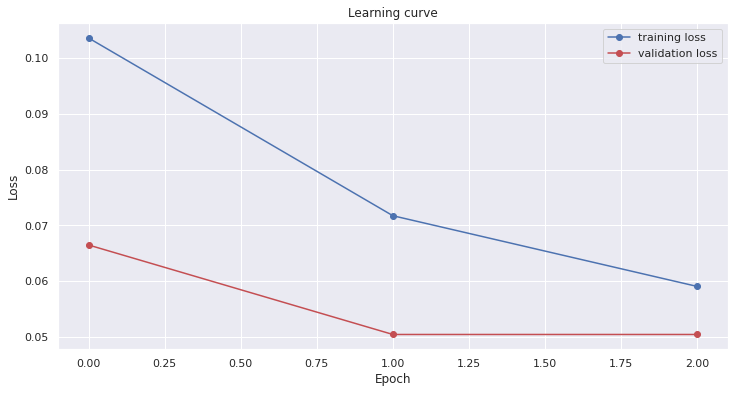

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [71]:
test_sentence = """Hello, my name is Jonathan and I live in Chicago along with my girlfriend Paige and my dog Goose.
Paige and myself are interested in moving to North Carolina, Tennessee, Washington, or Colorado if we get the opportunity.
I hope to work as a data scientist, and Paige wants to be the Hokage of the Hidden Leaf Village."""

In [72]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [73]:
with torch.no_grad():
    output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

In [74]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [75]:
for token, label in zip(new_tokens, new_labels):
    print('{}\t{}'.format(label,token))

O	[CLS]
B-per	Hello
O	,
O	my
O	name
O	is
B-per	Jonathan
O	and
O	I
O	live
O	in
B-geo	Chicago
O	along
O	with
O	my
O	girlfriend
B-per	Paige
O	and
O	my
O	dog
B-per	Goose
O	.
B-per	Paige
O	and
O	myself
O	are
O	interested
O	in
O	moving
O	to
B-geo	North
I-geo	Carolina
O	,
B-geo	Tennessee
O	,
B-geo	Washington
O	,
O	or
B-geo	Colorado
O	if
O	we
O	get
O	the
O	opportunity
O	.
O	I
O	hope
O	to
O	work
O	as
O	a
O	data
O	scientist
O	,
O	and
B-per	Paige
O	wants
O	to
O	be
O	the
B-org	Hokage
O	of
O	the
B-org	Hidden
I-org	Leaf
I-org	Village
O	.
O	[SEP]
